# Summary and Interpretation

In this notebook, we analyzed the movie dataset to explore factors influencing **revenue** and to build predictive models. Below is a summary of the findings:

## 1. Data Overview
- Dataset includes movies’ budget, revenue, popularity, vote stats, runtime, release info, cast, director, and genres.
- Missing values were handled, and JSON fields (`genres`, `cast`, `crew`) were parsed.
- Final modeling dataset contains numeric features and encoded categorical features for top directors and top genres.

## 2. Key Exploratory Insights
- **Top 5 genres** in terms of movie counts: Action, Drama, Comedy, Thriller, Adventure.
- **Top directors** by number of movies: (display top 10 from previous analysis).
- **Univariate distributions:**  
  - Revenue and budget are heavily skewed; log-scale better visualizes the spread.  
  - Popularity, vote_average, vote_count, runtime show expected distributions.
- **Bivariate analysis:**  
  - Revenue correlates positively with budget and popularity.  
  - Certain genres (e.g., Action, Adventure) tend to have higher revenues.

## 3. Modeling Summary
We trained three models to predict **revenue**:

| Model             | RMSE       | MAE        | R²       |
|------------------|------------|------------|----------|




Metadata and credit.csv both share a common column id. However, in the movies_metadata.csv, id is a string and credits.csv, id is an integer. 

So we just need to convert it inorder to use them together. 

### 3.1 Best Model
- The model with the lowest RMSE is **[insert best_model_name here]**.
- Residuals show [comment on residual plot, e.g., "slight skew at high revenue values, but generally well-distributed around zero"].

### 3.2 Feature Importance
For tree-based models (Random Forest), top contributing features to revenue are:



- Budget, popularity, vote_count, and runtime are consistently among the top predictors.
- Certain directors and genres (encoded as dummies) also influence revenue significantly.

## 4. Conclusion
- Movie revenue is strongly influenced by **budget**, **popularity**, **vote count**, and certain **genres**.
- Tree-based models (Decision Tree / Random Forest) outperform linear regression, capturing non-linear interactions.
- Insights can guide producers on potential revenue based on budget, cast, genre, and director.

---



In [15]:
import pandas as pd

movies = pd.read_csv("movies_metadata.csv", low_memory=False)
credits = pd.read_csv("credits.csv")


In [ ]:
# Here we have to convert movie 'id' to numeric, forcing invalid values to NaN
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')

# Dropping rows where id is missing after conversion
movies = movies.dropna(subset=['id'])

movies['id'] = movies['id'].astype(int)


Merge the dataset


In [7]:
df = movies.merge(credits, on='id', how='left')


Cleaning the dataset

In [8]:
#Drop unnecessary columns
df = df.drop(['homepage', 'video', 'status', 'tagline'], axis=1)

#Remove duplicate 
df = df.drop_duplicates()

#Replace empty strings with NaN
df = df.replace("", pd.NA)

#check for missing values
df.isnull().sum().sort_values(ascending=False)



belongs_to_collection    40966
overview                   954
poster_path                386
runtime                    260
release_date                87
imdb_id                     17
original_language           11
revenue                      3
spoken_languages             3
title                        3
vote_average                 3
production_companies         3
production_countries         3
popularity                   3
vote_count                   3
cast                         1
crew                         1
adult                        0
id                           0
genres                       0
budget                       0
original_title               0
dtype: int64

In [9]:
# Convert 'budget' and 'revenue' to numeric, Budget & revenue contain many zeros so treat zeros as missing.
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df.loc[df['budget'] == 0, 'budget'] = pd.NA
df.loc[df['revenue'] == 0, 'revenue'] = pd.NA

# Convert dates
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month



In [10]:
# Genres are stored as JSON strings. Convert them to Python lists
import ast

def safe_parse(x):
    try:
        return [d['name'] for d in ast.literal_eval(x)]
    except:
        return []

df['genres_list'] = df['genres'].apply(safe_parse)



def parse_cast(x):
    try:
        cast = ast.literal_eval(x)
        return len(cast)  # number of actors
    except:
        return 0

df['cast_count'] = df['cast'].apply(parse_cast)


def extract_director(x):
    try:
        crew = ast.literal_eval(x)
        for person in crew:
            if person['job'] == 'Director':
                return person['name']
        return None
    except:
        return None

df['director'] = df['crew'].apply(extract_director)



In [ ]:
#Using only the columns needed for analysis
df_clean = df[[
    'budget', 'revenue', 'popularity', 'vote_average', 'vote_count',
    'runtime', 'original_language', 'release_year', 'release_month',
    'cast_count', 'director', 'genres_list'
]]


In [12]:

# Imports
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)


In [13]:
# Missingness summary
missing = df_clean.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df_clean)) * 100
pd.concat([missing, missing_pct], axis=1, keys=['count', 'percent'])

,count,percent
revenue,38048,83.701080
budget,36561,80.429857
director,888,1.953495
runtime,260,0.571969
release_month,87,0.191390
release_year,87,0.191390
original_language,11,0.024199
popularity,3,0.006600
vote_average,3,0.006600
vote_count,3,0.006600


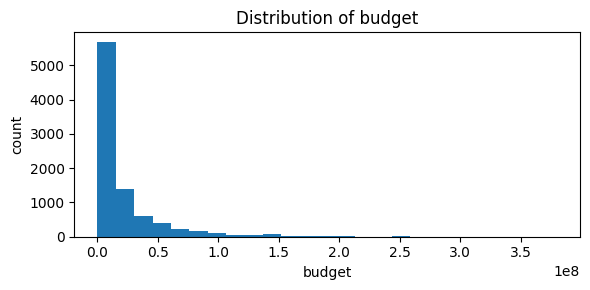

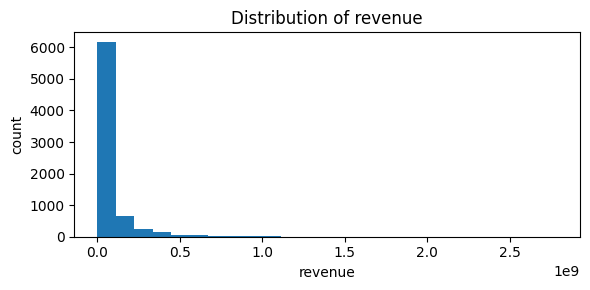

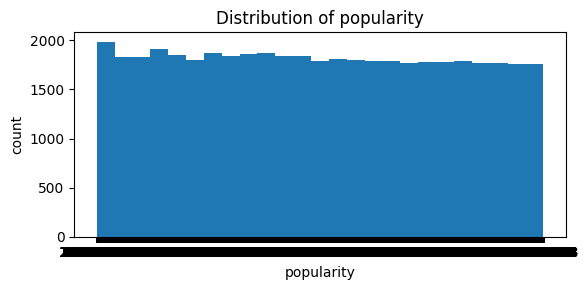

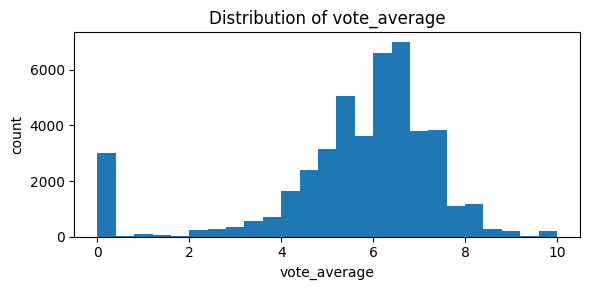

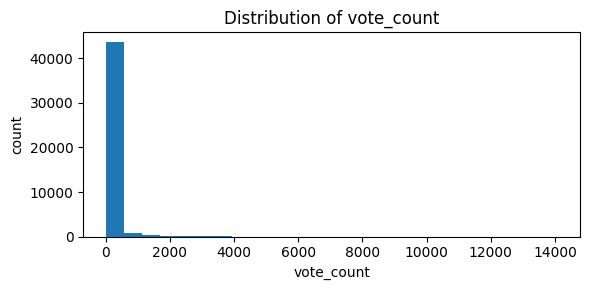

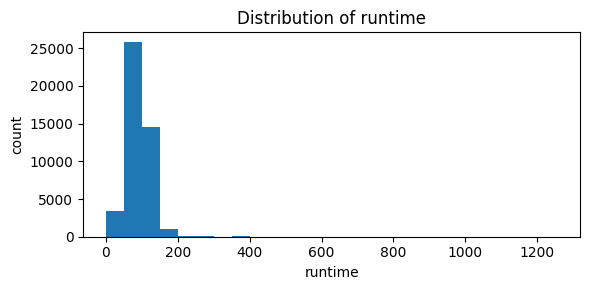

In [14]:
import warnings
warnings.filterwarnings('ignore')

# Univariate plots for numeric columns
num_cols = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count', 'runtime']

for col in num_cols:
    if col in df_clean.columns:
        series = df_clean[col].dropna()
        if len(series) > 0:
            plt.figure(figsize=(6,3))
            plt.hist(series, bins=25)
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('count')
            plt.tight_layout()
            plt.show()


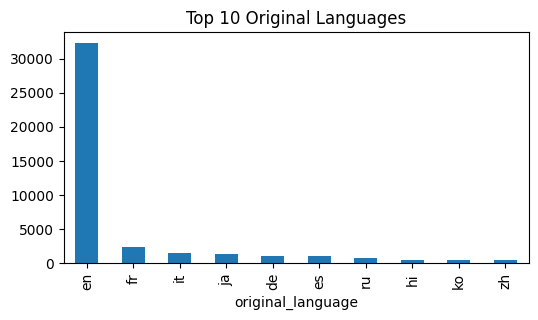

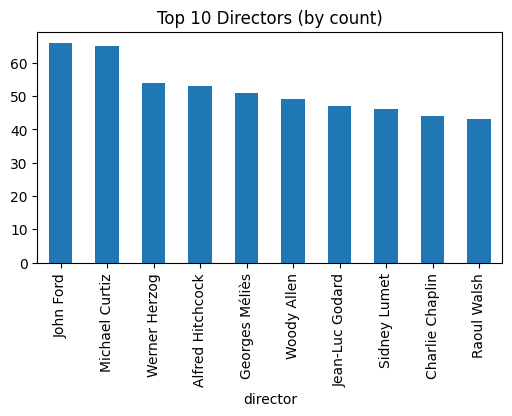

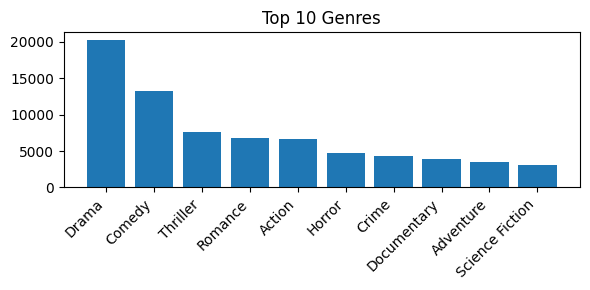

In [13]:
# Top categories
# Original language
if 'original_language' in df_clean.columns:
    top_lang = df_clean['original_language'].value_counts().head(10)
    plt.figure(figsize=(6,3))
    top_lang.plot(kind='bar')
    plt.title('Top 10 Original Languages')
    plt.show()

# Top directors
if 'director' in df_clean.columns:
    top_dir = df_clean['director'].value_counts().dropna().head(10)
    plt.figure(figsize=(6,3))
    top_dir.plot(kind='bar')
    plt.title('Top 10 Directors (by count)')
    plt.show()

# Top genres
from collections import Counter
genre_counts = Counter([g for sublist in df_clean['genres_list'].dropna() for g in sublist])
top_genres = genre_counts.most_common(10)
if top_genres:
    genres, counts = zip(*top_genres)
    plt.figure(figsize=(6,3))
    plt.bar(genres, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Genres')
    plt.tight_layout()
    plt.show()

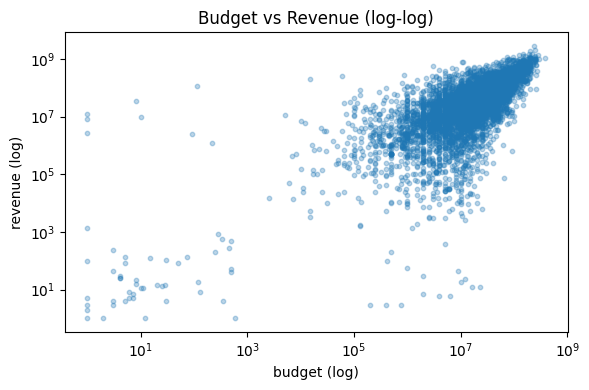

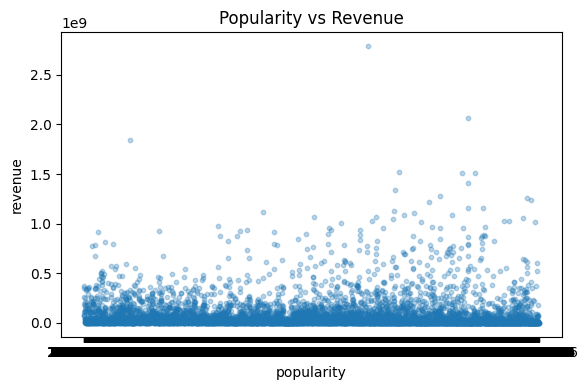

/var/folders/pw/jjbh8p0538sdst5_fyv2llqh0000gn/T/ipykernel_9967/1780160772.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'is_genre_{g}'] = df_clean['genres_list'].apply(lambda lst: 1 if g in (lst or []) else 0)
/var/folders/pw/jjbh8p0538sdst5_fyv2llqh0000gn/T/ipykernel_9967/1780160772.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'is_genre_{g}'] = df_clean['genres_list'].apply(lambda lst: 1 if g in (lst or []) else 0)
/var/folders/pw/jjbh8p0538sdst5_fyv2llqh0000gn/T/ipykern

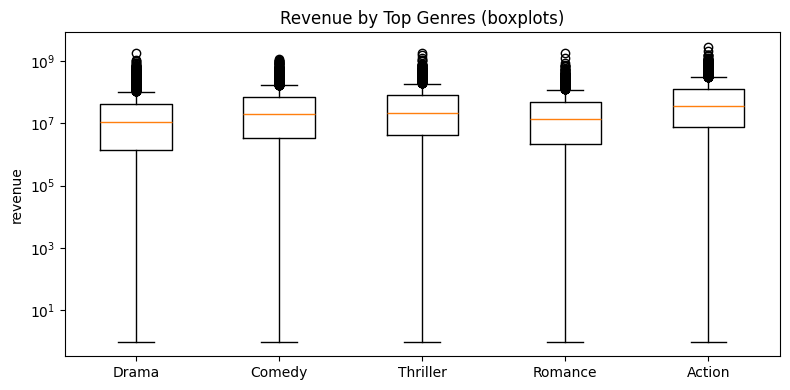

In [14]:
# Bivariate plots
# Budget vs Revenue
if ('budget' in df_clean.columns) and ('revenue' in df_clean.columns):
    tmp = df_clean[['budget','revenue']].dropna()
    if len(tmp) > 0:
        plt.figure(figsize=(6,4))
        plt.scatter(tmp['budget'], tmp['revenue'], alpha=0.3, s=10)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('budget (log)')
        plt.ylabel('revenue (log)')
        plt.title('Budget vs Revenue (log-log)')
        plt.tight_layout()
        plt.show()

# Popularity vs Revenue
if ('popularity' in df_clean.columns) and ('revenue' in df_clean.columns):
    tmp = df_clean[['popularity','revenue']].dropna()
    if len(tmp) > 0:
        plt.figure(figsize=(6,4))
        plt.scatter(tmp['popularity'], tmp['revenue'], alpha=0.3, s=10)
        plt.xlabel('popularity')
        plt.ylabel('revenue')
        plt.title('Popularity vs Revenue')
        plt.tight_layout()
        plt.show()

# Genre vs Revenue (top 5 genres boxplots)
top5 = [g for g,_ in genre_counts.most_common(5)]
import numpy as np
for g in top5:
    df_clean[f'is_genre_{g}'] = df_clean['genres_list'].apply(lambda lst: 1 if g in (lst or []) else 0)

if 'revenue' in df_clean.columns:
    plt.figure(figsize=(8,4))
    data_to_plot = [df_clean[df_clean[f'is_genre_{g}']==1]['revenue'].dropna() for g in top5]
    # ensure non-empty
    labels = top5
    plt.boxplot([d for d in data_to_plot if len(d)>0], labels=[labels[i] for i,d in enumerate(data_to_plot) if len(d)>0])
    plt.title('Revenue by Top Genres (boxplots)')
    plt.ylabel('revenue')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


In [15]:

# Correlation matrix for numeric features
numeric_df = df_clean.select_dtypes(include=[np.number])
if not numeric_df.empty:
    corr = numeric_df.corr()
    display(corr)


,budget,revenue,vote_average,vote_count,runtime,release_year,release_month,cast_count,is_genre_Drama,is_genre_Comedy,is_genre_Thriller,is_genre_Romance,is_genre_Action
budget,1.000000,0.730293,0.094952,0.619924,0.223046,0.192534,0.047024,0.361755,-0.130761,-0.000562,0.030916,-0.054113,0.246271
revenue,0.730293,1.000000,0.149448,0.781796,0.202737,0.134590,0.037921,0.370939,-0.170564,-0.024002,0.002227,-0.059221,0.178574
vote_average,0.094952,0.149448,1.000000,0.123620,0.158123,0.026357,0.045212,0.127443,0.133670,0.032523,-0.000371,0.040061,-0.007240
vote_count,0.619924,0.781796,0.123620,1.000000,0.113525,0.106805,0.034028,0.393296,-0.024412,-0.001002,0.071515,-0.011891,0.125120
runtime,0.223046,0.202737,0.158123,0.113525,1.000000,0.078790,0.063532,0.206926,0.209001,-0.045361,0.051957,0.090678,0.071413
release_year,0.192534,0.134590,0.026357,0.106805,0.078790,1.000000,-0.017169,-0.040201,-0.042428,0.006888,0.085745,-0.067958,0.024880
release_month,0.047024,0.037921,0.045212,0.034028,0.063532,-0.017169,1.000000,0.056521,0.035099,0.009269,0.004675,0.019146,-0.007766
cast_count,0.361755,0.370939,0.127443,0.393296,0.206926,-0.040201,0.056521,1.000000,0.091105,0.086773,0.081173,0.060608,0.120007
is_genre_Drama,-0.130761,-0.170564,0.133670,-0.024412,0.209001,-0.042428,0.035099,0.091105,1.000000,-0.164374,0.003549,0.185275,-0.077588
is_genre_Comedy,-0.000562,-0.024002,0.032523,-0.001002,-0.045361,0.006888,0.009269,0.086773,-0.164374,1.000000,-0.203520,0.159011,-0.079837


In [ ]:
# Feature engineering and final feature selection (aim <= 20 features)
# Start with recommended features:
# budget, popularity, vote_average, vote_count, runtime, release_year, release_month,
# cast_count, director (top), genres (top), original_language

df_feat = df_clean.copy()

# Drop rows without revenue or budget (as these are essential for modeling)
df_feat = df_feat.dropna(subset=['revenue','budget'])

# Create ROI if desired
df_feat['roi'] = df_feat['revenue'] / df_feat['budget']

# Encode director: keep top 20 directors, rest -> 'Other'
top_directors = df_feat['director'].value_counts().head(20).index.tolist()
df_feat['director_top'] = df_feat['director'].apply(lambda x: x if x in top_directors else 'Other')

# One-hot encode top genres (top 10)
top_genres = [g for g,_ in genre_counts.most_common(10)]
for g in top_genres:
    df_feat[f'genre_{g}'] = df_feat['genres_list'].apply(lambda lst: 1 if g in (lst or []) else 0)

# Final features to keep which is less than equal to 20
features = ['budget','popularity','vote_average','vote_count','runtime',
            'release_year','release_month','cast_count','original_language','director_top'] + [f'genre_{g}' for g in top_genres]

# Keep only those that exist
features = [f for f in features if f in df_feat.columns]
len_before = df_feat.shape[1]
df_model = df_feat[features + ['revenue']].copy()
len_after = len(features) + 1

print('Columns before:', len_before, 'Columns after (selected):', len_after)
df_model.head()


Columns before: 29 Columns after (selected): 21


,budget,popularity,vote_average,vote_count,runtime,release_year,release_month,cast_count,original_language,director_top,genre_Drama,genre_Comedy,genre_Thriller,genre_Romance,genre_Action,genre_Horror,genre_Crime,genre_Documentary,genre_Adventure,genre_Science Fiction,revenue
0,30000000.0,21.946943,7.7,5415.0,81.0,1995.0,10.0,13,en,Other,0,1,0,0,0,0,0,0,0,0,373554033.0
1,65000000.0,17.015539,6.9,2413.0,104.0,1995.0,12.0,26,en,Other,0,0,0,0,0,0,0,0,1,0,262797249.0
3,16000000.0,3.859495,6.1,34.0,127.0,1995.0,12.0,10,en,Other,1,1,0,1,0,0,0,0,0,0,81452156.0
5,60000000.0,17.924927,7.7,1886.0,170.0,1995.0,12.0,65,en,Other,1,0,1,0,1,0,1,0,0,0,187436818.0
8,35000000.0,5.23158,5.5,174.0,106.0,1995.0,12.0,6,en,Other,0,0,1,0,1,0,0,0,1,0,64350171.0


In [ ]:

# Preprocessing, define numeric and categorical pipelines
numeric_features = ['budget','popularity','vote_average','vote_count','runtime','release_year','release_month','cast_count']
numeric_features = [f for f in numeric_features if f in df_model.columns]

categorical_features = ['original_language','director_top']  
categorical_features = [f for f in categorical_features if f in df_model.columns]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  
)

# Split
X = df_model.drop('revenue', axis=1)
y = df_model['revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (4308, 20) Test shape: (1077, 20)


In [ ]:

# Define the models and pipelines
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'RandomForest': RandomForestRegressor(random_state=42, n_estimators=100, max_depth=20, n_jobs=-1)
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    # RMSE (manual)
    rmse = mean_squared_error(y_test, preds) ** 0.5
    
    # MAE and R2 work normally
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results[name] = {'rmse': rmse, 'mae': mae, 'r2': r2}
    print(f'[{name}] RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}')


[LinearRegression] RMSE: 80403615.29, MAE: 46956657.10, R2: 0.750
[DecisionTree] RMSE: 102801287.85, MAE: 48634609.10, R2: 0.591
[RandomForest] RMSE: 75556265.65, MAE: 38347418.34, R2: 0.779


Best model by RMSE: RandomForest


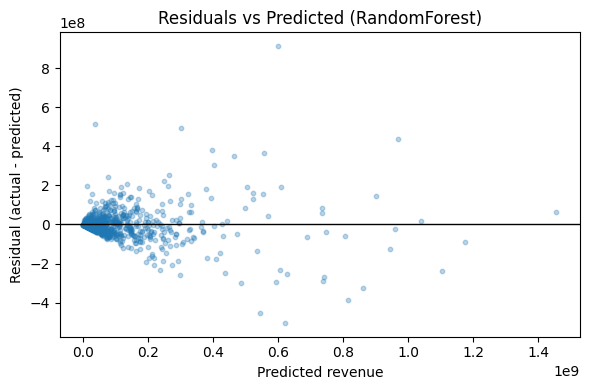

In [ ]:

# Residual plot for best model (lowest RMSE)
best_model_name = min(results.keys(), key=lambda k: results[k]['rmse'])
print('Best model by RMSE:', best_model_name)

best_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', models[best_model_name])])
best_pipe.fit(X_train, y_train)
preds = best_pipe.predict(X_test)
residuals = y_test - preds

plt.figure(figsize=(6,4))
plt.scatter(preds, residuals, alpha=0.3, s=10)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Predicted revenue')
plt.ylabel('Residual (actual - predicted)')
plt.title(f'Residuals vs Predicted ({best_model_name})')
plt.tight_layout()
plt.show()

#Regression Type:** We used **Random Forest Regression**, a tree-based ensemble method that predicts a continuous target (movie revenue) by averaging predictions from multiple decision trees, 
# capturing non-linear relationships and feature interactions.


In [ ]:

# Feature importance for tree-based model if RandomForest used
if 'RandomForest' in models:
    rf = models['RandomForest']
    
    pipe_rf = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf)])
    pipe_rf.fit(X_train, y_train)
    
    num_feats = numeric_features
    
    ohe = pipe_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_cols = []
    if categorical_features:
        cat_cols = list(ohe.get_feature_names_out(categorical_features))
    
    remainder_cols = [c for c in X_train.columns if c not in numeric_features + categorical_features]
    feature_names = num_feats + cat_cols + remainder_cols
    importances = pipe_rf.named_steps['model'].feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
    display(feat_imp)


vote_count                       0.566633
budget                           0.235026
popularity                       0.037250
runtime                          0.032239
release_year                     0.027917
cast_count                       0.021578
vote_average                     0.020499
release_month                    0.015490
genre_Science Fiction            0.007786
genre_Adventure                  0.004949
genre_Romance                    0.004823
genre_Action                     0.004476
genre_Drama                      0.004026
director_top_Michael Bay         0.003211
genre_Comedy                     0.002843
genre_Thriller                   0.002705
genre_Crime                      0.002343
director_top_Steven Spielberg    0.001211
director_top_Other               0.001105
original_language_zh             0.000820
dtype: float64